Some comments from [@sokrypton](https://github.com/sokrypton/)

*   The 3rd track in Rosettafold is essentially doing what alphafold triangle 
attention is doing. Adding a 3D bias to the attention. In Rosettafold this is done explicitly via evolving 3D coordinates. 

*   In alphafold this is done implicitly by essentially learning triangle inequality. Often if your distance matrix satisfies the condition that all three distances form a triangle, it is possible to embed structure in 3D space.

*   The potential benefit of 3D track is that you remove the expensive L^3 operation and replace this with L^2.

*   The potential negative part is that you can get stuck in local minimum as explicit 3D structure maybe harder to refine iteratively compared to a 2D distance matrix, which is not explicitly forced to be a valid distance matrix at each step of the evoformer. 

*   So it possible alphafold learned to not enforce triangle inequality at early layers, but then enforces them in latter layers.

See also [these AI conversation logs](https://poe.com/s/03iamy0dmmJF3023ccNp)

In [1]:
import torch
import torch.nn as nn

from typing import Dict, Optional, Callable , List, Any
from functools import partial
from collections.abc import Iterable

In [2]:
# Reference : https://github.com/dptech-corp/Uni-Core/blob/854b8890daa5722ba4e30eed1973564671611f6f/unicore/utils.py

def dict_map(fn, dic, leaf_type):
    new_dict = {}
    for k, v in dic.items():
        if type(v) is dict:
            new_dict[k] = dict_map(fn, v, leaf_type)
        else:
            new_dict[k] = tree_map(fn, v, leaf_type)
    return new_dict

def tree_map(fn, tree, leaf_type):
    if isinstance(tree, dict):
        return dict_map(fn, tree, leaf_type)
    elif isinstance(tree, list):
        return [tree_map(fn, x, leaf_type) for x in tree]
    elif isinstance(tree, tuple):
        return tuple([tree_map(fn, x, leaf_type) for x in tree])
    elif isinstance(tree, leaf_type):
        try:
            return fn(tree)
        except:
            raise ValueError(f"cannot apply {fn} on {tree}.")
    else:
        raise ValueError(f"{type(tree)} not supported")
tensor_tree_map = partial(tree_map, leaf_type=torch.Tensor)

def permute_final_dims(tensor: torch.Tensor, inds: List[int]):
    zero_index = -1 * len(inds)
    first_inds = list(range(len(tensor.shape[:zero_index])))
    return tensor.permute(first_inds + [zero_index + i for i in inds])

In [3]:
# Reference : https://github.com/dptech-corp/Uni-Fold/blob/1a301710392ecf97991aebc3276aad9d0f77178f/unifold/modules/common.py#L299

def chunk_layer(
    layer: Callable,
    inputs: Dict[str, Any],
    chunk_size: int,
    num_batch_dims: int,
) -> Any:
    # TODO: support inplace add to output
    if not (len(inputs) > 0):
        raise ValueError("Must provide at least one input")
    def _dict_get_shapes(input):
        shapes = []
        if type(input) is torch.Tensor:
            shapes.append(input.shape)
        elif type(input) is dict:
            for v in input.values():
                shapes.extend(_dict_get_shapes(v))
        elif isinstance(input, Iterable):
            for v in input:
                shapes.extend(_dict_get_shapes(v))
        else:
            raise ValueError("Not supported")
        return shapes
    inputs = {k: v for k, v in inputs.items() if v is not None}
    initial_dims = [shape[:num_batch_dims] for shape in _dict_get_shapes(inputs)]
    orig_batch_dims = tuple([max(s) for s in zip(*initial_dims)])
    flat_batch_dim = 1
    for d in orig_batch_dims:
        flat_batch_dim *= d
    num_chunks = (flat_batch_dim + chunk_size - 1) // chunk_size
    def _flat_inputs(t):
        t = t.view(-1, *t.shape[num_batch_dims:])
        assert (
            t.shape[0] == flat_batch_dim or t.shape[0] == 1
        ), "batch dimension must be 1 or equal to the flat batch dimension"
        return t
    flat_inputs = tensor_tree_map(_flat_inputs, inputs)
    out = None
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = min((i + 1) * chunk_size, flat_batch_dim)
        def select_chunk(t):
            if t.shape[0] == 1:
                return t[0:1]
            else:
                return t[chunk_start:chunk_end]
        chunkes = tensor_tree_map(select_chunk, flat_inputs)
        output_chunk = layer(**chunkes)
        if out is None:
            out = tensor_tree_map(
                lambda t: t.new_zeros((flat_batch_dim,) + t.shape[1:]), output_chunk
            )
        out_type = type(output_chunk)
        if out_type is tuple:
            for x, y in zip(out, output_chunk):
                x[chunk_start:chunk_end] = y
        elif out_type is torch.Tensor:
            out[chunk_start:chunk_end] = output_chunk
        else:
            raise ValueError("Not supported")
    reshape = lambda t: t.view(orig_batch_dims + t.shape[1:])
    out = tensor_tree_map(reshape, out)
    return out

In [4]:
# Modified from https://github.com/dptech-corp/Uni-Fold/blob/1a301710392ecf97991aebc3276aad9d0f77178f/unifold/modules/attentions.py#L349-L402

class TriangleAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_hid,
        num_heads,
        starting,
    ):
        super(TriangleAttention, self).__init__()
        self.starting = starting
        self.layer_norm = nn.LayerNorm(d_in)
        self.linear = nn.Linear(d_in, num_heads, bias=False)
        self.mha = nn.MultiheadAttention(d_hid, num_heads)
    @torch.jit.ignore
    def _chunk(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        bias: Optional[torch.Tensor] = None,
        chunk_size: int = None,
    ) -> torch.Tensor:
        return chunk_layer(
            self.mha,
            {"q": x, "k": x, "v": x, "mask": mask, "bias": bias},
            chunk_size=chunk_size,
            num_batch_dims=len(x.shape[:-2]),
        )
    def forward(
        self,
        x: torch.Tensor,
        attn_mask: Optional[torch.Tensor] = None,
        chunk_size: Optional[int] = None,
    ) -> torch.Tensor:
        if not self.starting:
            x = x.transpose(-2, -3)
        x = self.layer_norm(x)
        triangle_bias = (
            permute_final_dims(self.linear(x), (2, 0, 1)).unsqueeze(-4).contiguous()
        )
        if chunk_size is not None:
            x = self._chunk(x, attn_mask, triangle_bias, chunk_size)
        else:
            x = self.mha(query=x, key=x, value=x)

        if not self.starting:
            x = x.transpose(-2, -3)
        return x
        
    def get_output_bias(self):
        return self.mha.get_output_bias()

In [5]:
class MyModelWithTriangleAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
        vocab_size = 1024
        self.vocab_size = vocab_size
        embedding_dim = 512
        hidden_size = 512
        num_heads = 16
        num_classes = 4

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.triangle_attn_layer = TriangleAttention(
            d_in = embedding_dim,
            d_hid = hidden_size,
            num_heads = num_heads,
            starting = True
        )
        
        self.fc = nn.Linear(vocab_size+hidden_size, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  
        
        x = self.triangle_attn_layer(x)  
        #print("len(x) = ", len(x))
        #assert x.shape[0] == x.shape[0], "Batch dimension must match"
        #assert x.shape[1] == 1 and x.shape[1] > 1, "Feature dimension must match"

        #print("x[0].shape = ", x[0].shape)
        #print("x[1].shape = ", x[1].shape)

        x = list(x)
        x[0] = x[0].reshape(1, 1024, 512)

        x = tuple(x)
        
        x = torch.cat((x[0], x[1]), dim=-1)

        x = self.fc(x)
        
        return x

model = MyModelWithTriangleAttention()

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

num_epochs = 20

inputs = []

for epoch in range(num_epochs):
    
    # Training loop...
    
    optimizer.zero_grad()
    input = torch.randint(low=0, high=1, size=(1024,1)).to(torch.long)
    inputs.append(input)

    logits = model(input)
    labels = torch.randint(low=0, high=1, size=(1,4))
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()

    print(f"epoch = {epoch} , loss = {loss}")

epoch = 0 , loss = 6.931471824645996
epoch = 1 , loss = 6.931471824645996
epoch = 2 , loss = 6.931471824645996
epoch = 3 , loss = 6.931471824645996
epoch = 4 , loss = 6.931471824645996
epoch = 5 , loss = 6.931471824645996
epoch = 6 , loss = 6.931471824645996
epoch = 7 , loss = 6.931471824645996
epoch = 8 , loss = 6.931471824645996
epoch = 9 , loss = 6.931471824645996
epoch = 10 , loss = 6.931471824645996
epoch = 11 , loss = 6.931471824645996
epoch = 12 , loss = 6.931471824645996
epoch = 13 , loss = 6.931471824645996
epoch = 14 , loss = 6.931471824645996
epoch = 15 , loss = 6.931471824645996
epoch = 16 , loss = 6.931471824645996
epoch = 17 , loss = 6.931471824645996
epoch = 18 , loss = 6.931471824645996
epoch = 19 , loss = 6.931471824645996


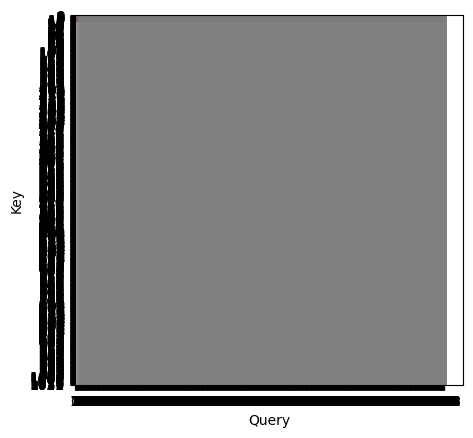

In [13]:
# Modified from code generated from AI chatbot

import matplotlib.pyplot as plt
import numpy as np

# Get sequence length
seq_len = model.vocab_size

# Initialize figure
fig, ax = plt.subplots()

# Plot heatmap
inputs = [input.to(torch.long).numpy() for input in inputs]
im = ax.imshow(inputs, cmap='RdBu', 
   interpolation='nearest')

# Label axes
ax.set_xlabel('Query')
ax.set_ylabel('Key')  
ax.set_xticks(np.arange(seq_len))
ax.set_yticks(np.arange(seq_len))

# Show triangle mask 
for i in range(seq_len):
    for j in range(i):
        ax.axvspan(i, seq_len, ymin=j, ymax=j+1, color='grey', alpha=0.2)

plt.show()